In [41]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import imodelsx.llm
from transformers import AutoModel, AutoTokenizer, pipeline
from tqdm import tqdm
from os.path import join
# import config
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import analyze_helper
from ridge_utils.features import qa_questions
# fit_encoding = __import__('01_fit_encoding')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_apr7'
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

100%|██████████| 415/415 [00:54<00:00,  7.66it/s]


experiment varied these params: ['subject', 'pc_components', 'distill_model_path', 'feature_space', 'feature_selection_alpha_index', 'qa_embedding_model', 'qa_questions_version', 'ndelays', 'seed']


# Check results

In [30]:
d = r
d = d[d.feature_selection_alpha_index >= 0]
d = d[r.distill_model_path.isna()]
cols_varied = [c for c in cols_varied if not c in [
    'distill_model_path']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets + ['weight_enet_mask_num_nonzero']].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by='corrs_tune_pc_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)
d = d.reset_index()

/tmp/ipykernel_2128152/3629166543.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = d[r.distill_model_path.isna()]


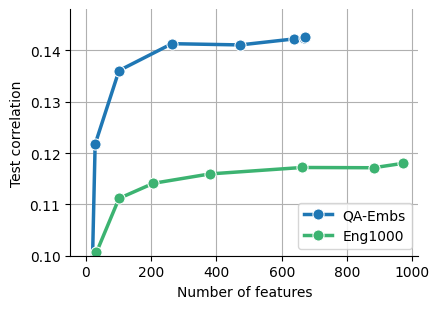

In [39]:
d = d[d.ndelays == 8]
d = d[d.subject == 'S03']
d = d[d.qa_embedding_model != 'mist-7B']

d['(qa_questions_version, ndelays)'] = list(
    zip(d.qa_questions_version, d.ndelays))
d['feature_space'] = d['feature_space'].map(
    lambda x: {'eng1000': 'Eng1000', 'qa_embedder-10': 'QA-Embs'}.get(x, x))
plt.figure(figsize=(4.5, 3.2))
ax = sns.lineplot(data=d,
                  x='weight_enet_mask_num_nonzero',
                  y='corrs_test_mean',
                  #  hue='(qa_questions_version, ndelays)',
                  hue_order=['QA-Embs', 'Eng1000'],
                  hue='feature_space',
                  palette=['C0', 'mediumseagreen'],
                  linewidth=2.5,
                  markersize=8,
                  marker='o')

# dvu.line_legend()
# plt.title('B', loc=, fontweight='bold')
plt.xlabel('Number of features')
plt.ylabel('Test correlation')

legend = ax.legend()
ax.legend().set_title('')

# set ylim bottom to 0.1
plt.ylim(bottom=0.1)
plt.grid()
plt.tight_layout()
plt.savefig('../figs/sparsity.pdf', bbox_inches='tight')
plt.show()

# Check sparsity levels

In [ ]:
sparse_feats_dir = join(config.repo_dir, 'sparse_feats')

In [ ]:
!ls {sparse_feats_dir}

In [ ]:
alphas_enet, coefs_enet = joblib.load(
    # join(sparse_feats_dir, 'v1_(0, -3, 15).joblib'))
    join(sparse_feats_dir, 'v3_boostexamples_(0, -3, 15).joblib'))

In [ ]:
for i in range(len(alphas_enet)):
    coef_enet = coefs_enet[:, :, i]
    coef_nonzero = np.any(np.abs(coef_enet) > 0, axis=0)
    print(f'{i=} alpha={alphas_enet[i]:.2e}, n_nonzero={coef_nonzero.sum()}')

### Top questions

In [ ]:
d = r[r.ndelays == 8]
row = d[(d.feature_selection_alpha_index == 3) *
        d.feature_space == 'qa_embedder-10'].iloc[0]

In [ ]:
row[['weights_enet', 'weight_enet_mask', 'weight_enet_mask_num_nonzero']]

In [ ]:
model_params = joblib.load(
    join(row.save_dir_unique, 'model_params.pkl'))

In [ ]:
model_params['weights'].shape

In [ ]:
ndelays = row.ndelays
# weights = model_params['weights']
weights = model_params['weights_pc']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays
weights = weights.reshape(ndelays, int(emb_size), -1)

In [ ]:
weights.shape

In [ ]:
for i in range(29):
    plt.plot(weights[:, i, 4])

In [ ]:
for i in range(29):
    plt.plot(np.abs(weights).mean(axis=-1)[:, i])
plt.xlabel('Delay offset (TRs-1)')
plt.show()

In [ ]:
qs = np.array(qa_questions.get_questions(row.qa_questions_version, full=True))

In [ ]:
mask = row.weight_enet_mask

In [ ]:
qs[mask]

In [ ]:
r['weight_enet_mask']